# Data explore

In [2]:
import pandas as pd
from data import parquet

dfData = parquet.read("./data/Carrickallen.parquet")
dfData.head()

,turbineid,datetime,avgwindspeed,avgpower,windspeedstandarddeviation,nacelleposition,avgwinddirection,availablepowerpublished,avgrotorspeed,avgpitchangle,...,rotordiameter,hubheight,groundlevelaltitude,dateinstalled,turbulent,underperformanceprobability,overperformanceprobability,turbulentvalid,underperformanceprobabilityvalid,overperformanceprobabilityvalid
0,CRKALN_001,2019-01-01 00:00:00,8.16,1180.48,20.160000,247.59,241.66,1042.36,14.51,0.09,...,92,74,44,2018-10-01,False,NaN,NaN,True,True,True
1,CRKALN_001,2019-01-01 00:10:00,7.41,919.05,20.480000,247.59,245.49,781.94,13.79,0.00,...,92,74,44,2018-10-01,False,NaN,NaN,True,True,True
2,CRKALN_001,2019-01-01 00:20:00,6.87,753.19,19.040001,247.59,245.45,611.98,13.07,0.00,...,92,74,44,2018-10-01,False,NaN,NaN,True,True,True
3,CRKALN_001,2019-01-01 00:30:00,7.27,909.52,15.360000,247.59,244.50,735.18,13.74,0.02,...,92,74,44,2018-10-01,False,NaN,NaN,True,True,True
4,CRKALN_001,2019-01-01 00:40:00,7.64,1040.67,17.920000,247.59,247.77,858.76,14.38,0.00,...,92,74,44,2018-10-01,False,NaN,NaN,True,True,True


In [3]:
for col in dfData.columns:
    print(col)
    print(dfData[col].describe())
    print("-"*50)

turbineid
count        2903497
unique            10
top       CRKALN_009
freq          290822
Name: turbineid, dtype: object
--------------------------------------------------
datetime
count                          2903497
mean     2021-11-15 15:00:51.818890240
min                2019-01-01 00:00:00
25%                2020-07-03 07:20:00
50%                2021-11-21 14:40:00
75%                2023-04-15 09:10:00
max                2024-08-31 23:50:00
Name: datetime, dtype: object
--------------------------------------------------
avgwindspeed
count    2.903356e+06
mean     6.556407e+00
std      3.204783e+00
min     -6.390000e+00
25%      4.310000e+00
50%      6.100000e+00
75%      8.350000e+00
max      3.963000e+01
Name: avgwindspeed, dtype: float64
--------------------------------------------------
avgpower
count    2.903497e+06
mean     6.612706e+02
std      6.319273e+02
min     -1.862000e+01
25%      1.311200e+02
50%      4.401600e+02
75%      1.083020e+03
max      2.061000e+03
N

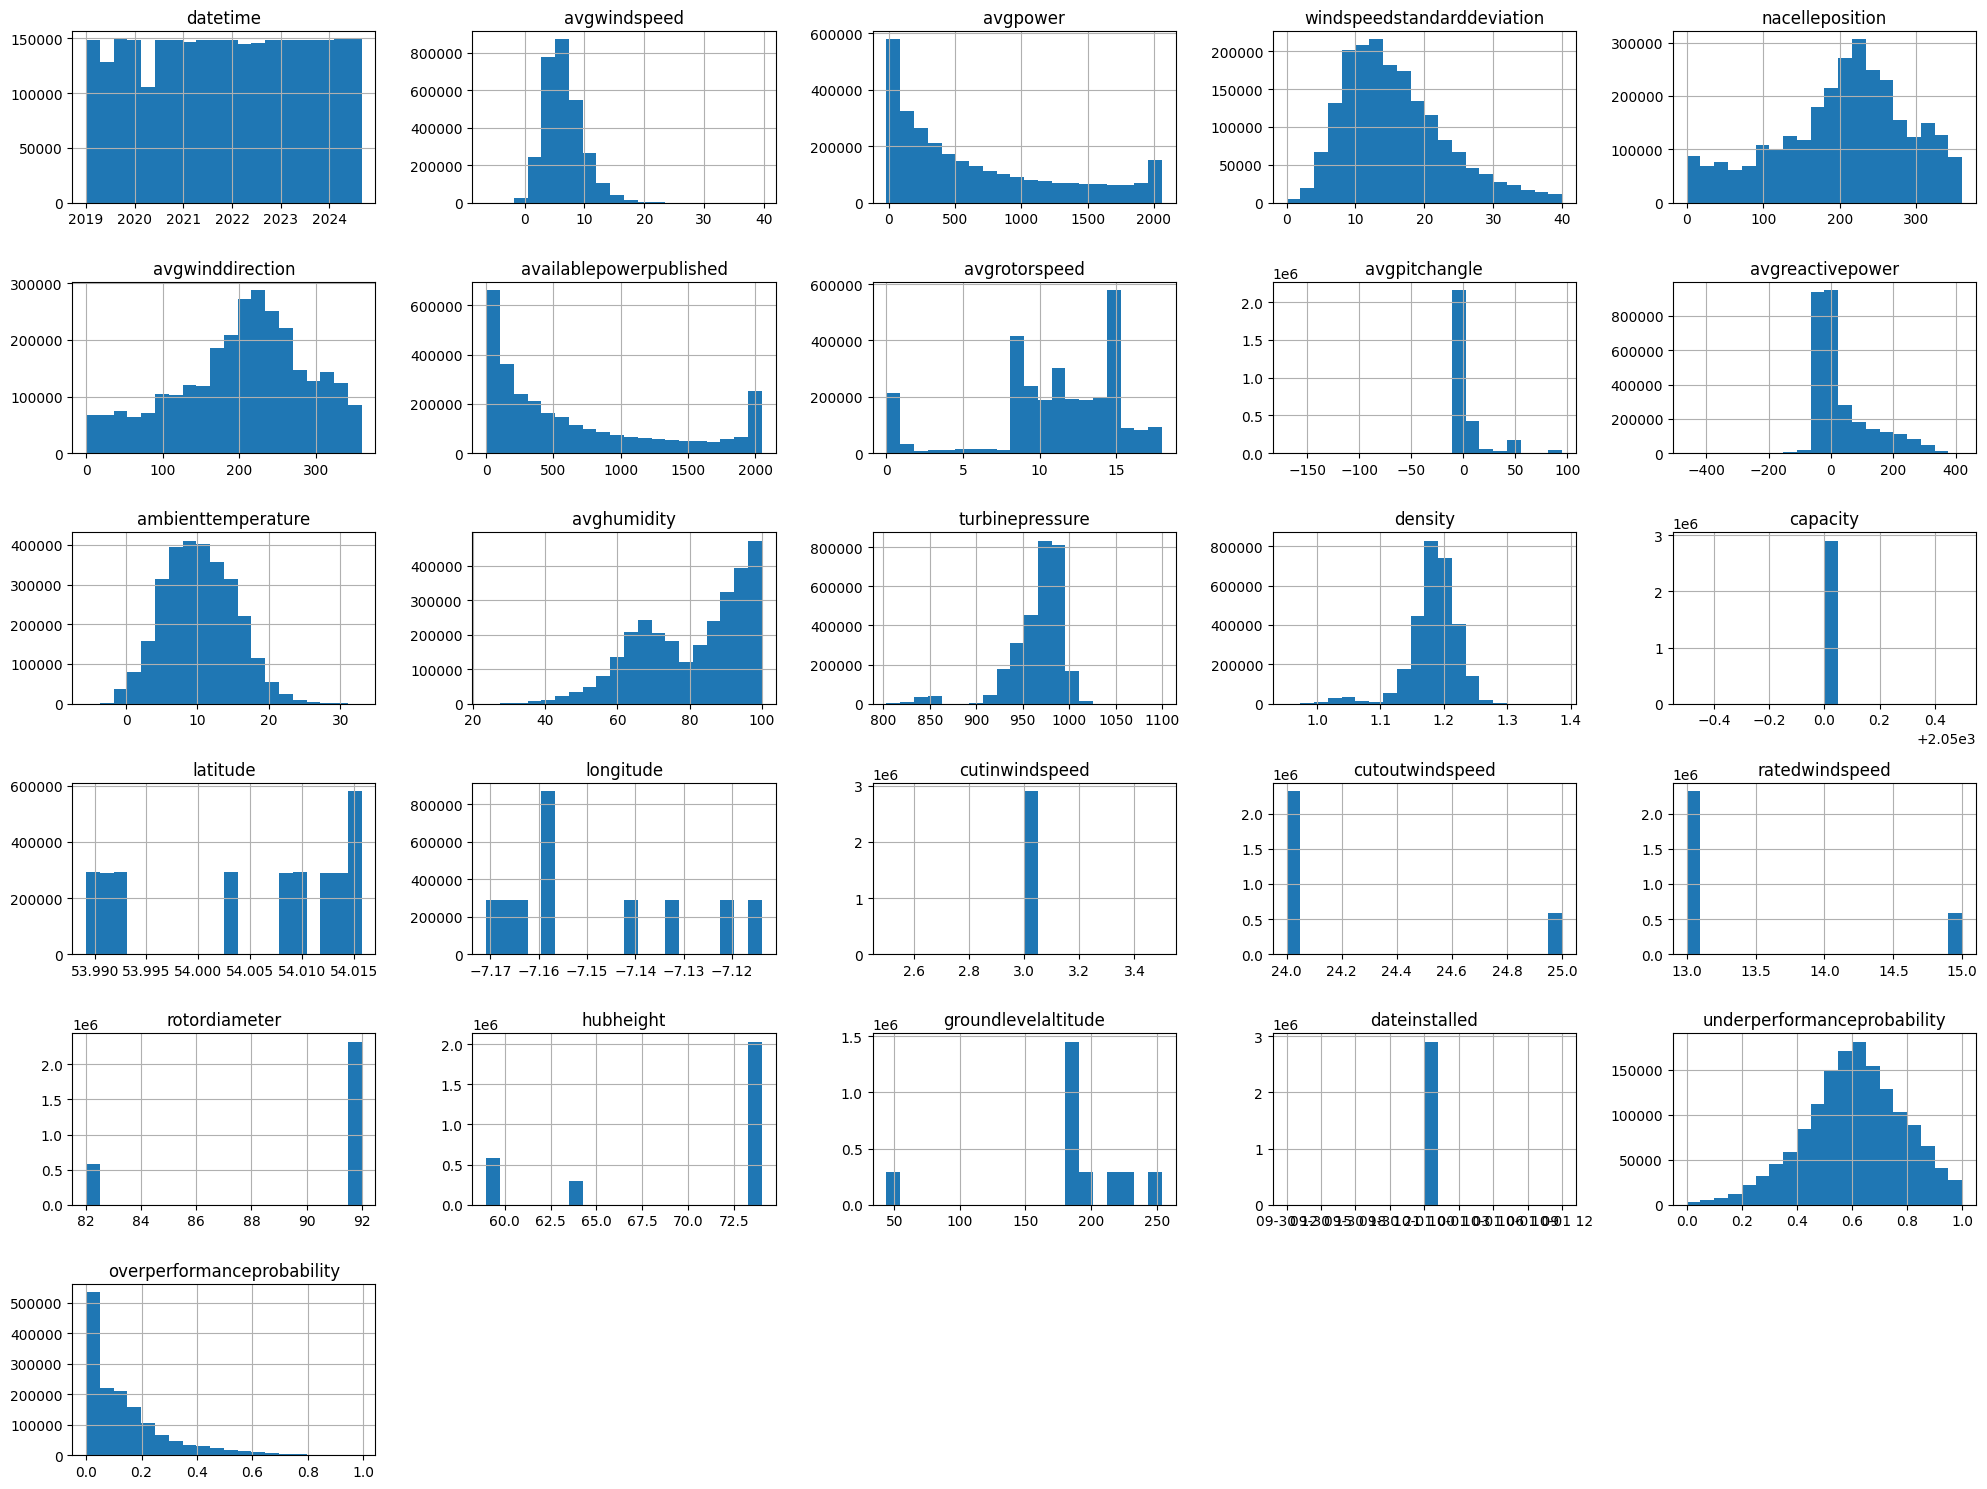

In [4]:
# plot hist for each column
def plotHist(dataDf):
    from matplotlib import pyplot as plt


    dataDf.hist(bins=20, figsize=(20,15), sharex=False, sharey=False)

    plt.tight_layout()
    plt.show()
    
plotHist(dfData)

## Trash Columns 

1. Prod_LatestAvg_ActPwrGen2: all values are zeros
1. Prod_LatestAvg_ReactPwrGen2: all values are zeros
1. Grd_Prod_Freq_Avg: values are in 50 +- 0.1
1. Prod_LatestAvg_ReactPwrGen0 & Prod_LatestAvg_ActPwrGen0: 50% and 75% = 0


## Suspicious Columns

1. Amb_WindSpeed_Std: Most of its value is in range [0, 10%]
1. Amb_WindDir_Relative_Avg: 25-75 is in much smaller range than min-max
1. Gen_RPM_Min & Gen_RPM_Avg: 25% is much smaller than the rest. Maybe 0 for missing
1. Prod_LatestAvg_ReactPwrGen1: value range is not normal, and its neighbors (Prod_LatestAvg_ReactPwrGen0, Prod_LatestAvg_ReactPwrGen2) is identified as trash
1. Prod_LatestAvg_TotActPwr: Most of its value is in range [0, 10%]
1. 

## Other
Some prod columns contain negative values



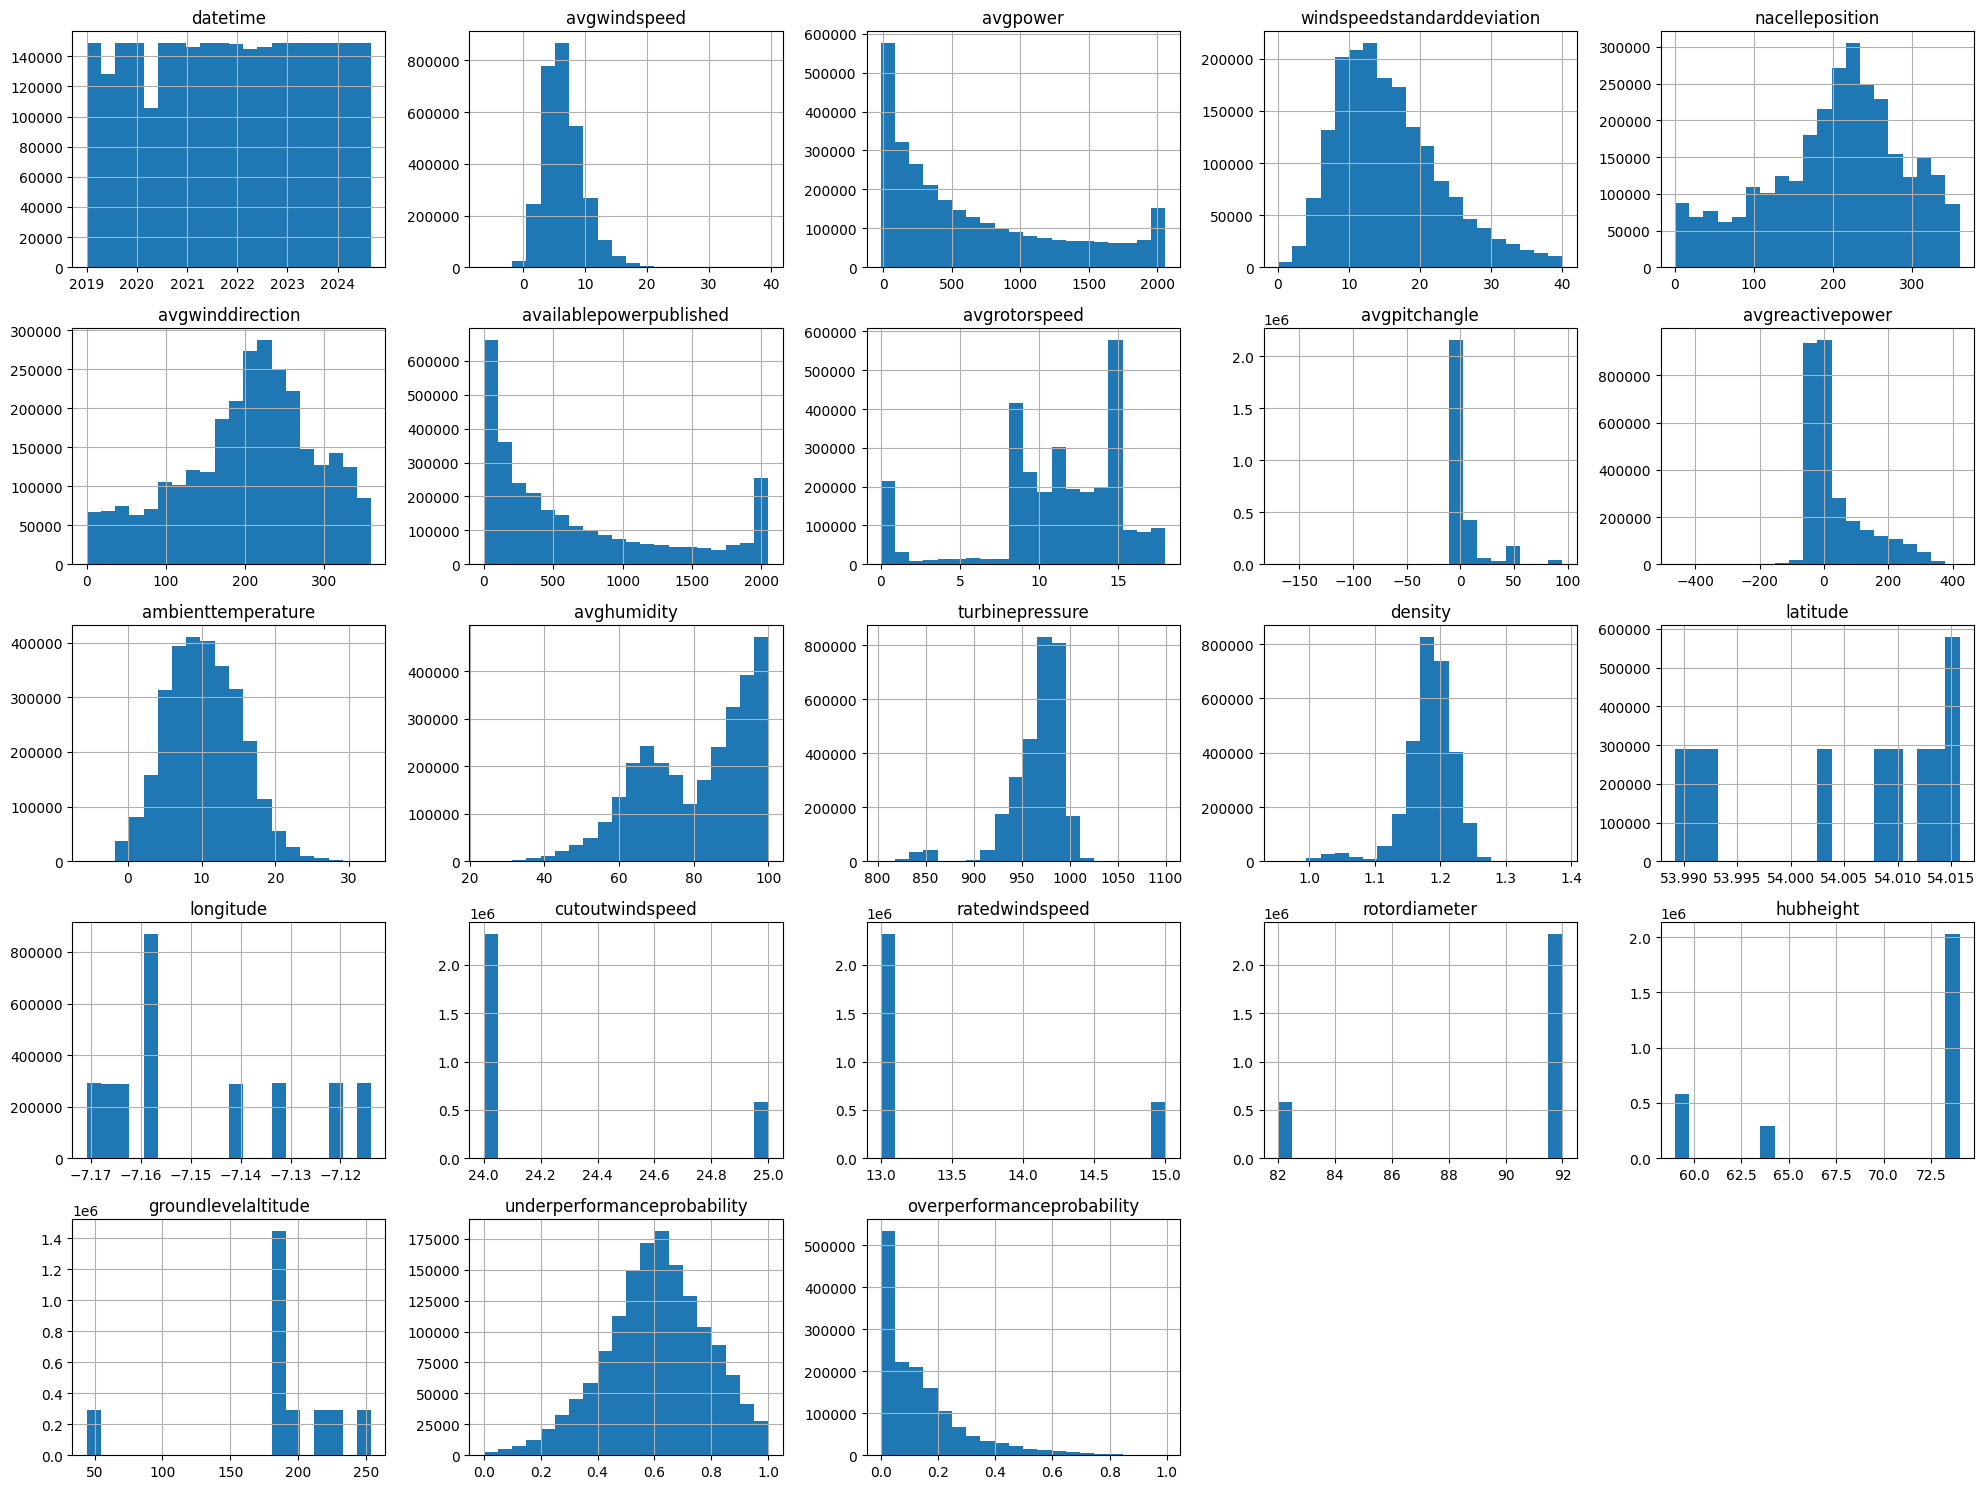

In [5]:
dfCleared = dfData[[col for col in dfData.columns if col not in [
    "capacity",
    "cutinwindspeed",
    "dateinstalled",
]]]

plotHist(dfCleared)
                   

# Power curve

In [6]:
# columns containing the word "Wind"
windCols = [col for col in dfData.columns if "wind" in col]

print(len(windCols))
windCols

6


['avgwindspeed',
 'windspeedstandarddeviation',
 'avgwinddirection',
 'cutinwindspeed',
 'cutoutwindspeed',
 'ratedwindspeed']

In [7]:
pwrCols = [col for col in dfData.columns if "power" in col.lower()]

print(len(pwrCols))
pwrCols

3


['avgpower', 'availablepowerpublished', 'avgreactivepower']

In [8]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


pwrCol = "avgpower"
windCol = "avgwindspeed"


def plotEnergyByWind(dataDf, output=None):
    bins = np.arange(0, dataDf[windCol].max(), 0.5)
    windBins = pd.cut(dataDf[windCol], bins, include_lowest=True)

    dfBinned = pd.DataFrame(
        {
            windCol: windBins,
            pwrCol: dataDf[pwrCol],
        }
    )

    grouped = dfBinned.groupby(windCol)[pwrCol]
    boxplot_data = [group.dropna().values for _, group in grouped]

    # draw an energy production curve
    plt.figure(figsize=(10, 6))
    plt.boxplot(boxplot_data, positions=range(len(boxplot_data)), widths=0.6)
    plt.plot()

    plt.title("Energy Production Curve", fontsize=14)
    plt.xlabel("Wind Speed", fontsize=12)
    plt.ylabel("Power Production", fontsize=12)

    bin_edges = [f"{interval.left}" for interval in windBins.cat.categories]
    ax = plt.gca()
    ax.set_xticks(range(len(bin_edges)))
    ax.set_xticklabels(bin_edges)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    if output:
        plt.savefig(output)
        plt.close()
    else:
        plt.show()

In [9]:
turbineIdx = dfData["turbineid"].unique()
turbineIdx

['CRKALN_001', 'CRKALN_002', 'CRKALN_003', 'CRKALN_004', 'CRKALN_005', 'CRKALN_006', 'CRKALN_007', 'CRKALN_008', 'CRKALN_009', 'CRKALN_010']
Categories (10, object): ['CRKALN_001', 'CRKALN_002', 'CRKALN_003', 'CRKALN_004', ..., 'CRKALN_007', 'CRKALN_008', 'CRKALN_009', 'CRKALN_010']

/tmp/ipykernel_226316/3802653947.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dfBinned.groupby(windCol)[pwrCol]


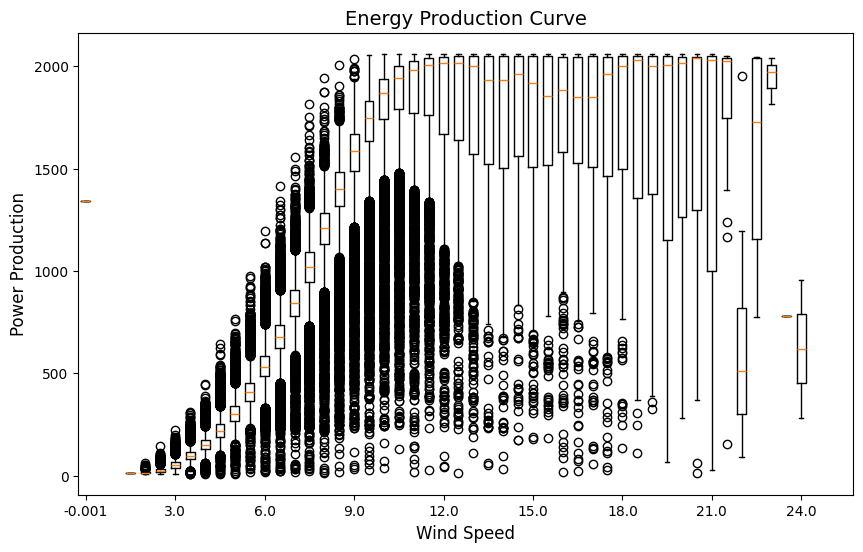

In [10]:
dfTurbine = dfData[dfData["turbineid"] == "CRKALN_001"]

dfTurbine = dfTurbine[dfTurbine["avgpower"] > 10]
plotEnergyByWind(dfTurbine)

In [14]:
from pathlib import Path


dfTurbine1 = dfData[dfData["turbineid"] == turbineIdx[0]]
dfTurbine1["datetime"] = pd.to_datetime(dfTurbine1["datetime"])

# # seperate into smaller df by time, 6 months
# min = dfTurbine1["datetime"].min()
# max = dfTurbine1["datetime"].max()

# interval = pd.date_range(min, max, freq="1ME").append(pd.DatetimeIndex([max]))

# Path("./output").mkdir(exist_ok=True)
# for i in range(len(interval)-1):
#     df = dfTurbine1[(dfTurbine1["datetime"] >= interval[i]) & (dfTurbine1["datetime"] < interval[i+1])]
#     plotEnergyByWind(df, f"./output/energy_curve_turbine1_{interval[i]}.svg")

/tmp/ipykernel_226316/2619129148.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTurbine1["datetime"] = pd.to_datetime(dfTurbine1["datetime"])


# Auto Encoder

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                64, 32, kernel_size=3, stride=2, padding=1, output_padding=1
            ),  
            nn.ReLU(),
            nn.ConvTranspose2d(
                32, 16, kernel_size=3, stride=2, padding=1, output_padding=1
            ),  
            nn.ReLU(),
            nn.ConvTranspose2d(
                16, 1, kernel_size=3, stride=2, padding=1, output_padding=1
            ),  
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize model, loss, and optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for images, _ in train_loader:
        images = images.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Save the model
torch.save(model.state_dict(), "autoencoder_cnn.pth")

print("Training complete!")

Index(['turbineid', 'datetime', 'avgwindspeed', 'avgpower',
       'windspeedstandarddeviation', 'nacelleposition', 'avgwinddirection',
       'availablepowerpublished', 'avgrotorspeed', 'avgpitchangle',
       'avgreactivepower', 'ambienttemperature', 'avghumidity',
       'turbinepressure', 'density', 'site', 'phase', 'manufacturer', 'model',
       'latitude', 'longitude', 'cutoutwindspeed', 'ratedwindspeed',
       'rotordiameter', 'hubheight', 'groundlevelaltitude', 'turbulent',
       'underperformanceprobability', 'overperformanceprobability',
       'turbulentvalid', 'underperformanceprobabilityvalid',
       'overperformanceprobabilityvalid'],
      dtype='object')